In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
#%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.base import load_dataset
from ganime.utils.statistics import dataset_statistics
from ganime.model.vqgan.vqgan import VQGAN
from ganime.visualization.videos import display_images, display_videos
import tensorflow as tf
from tqdm import tqdm
#tf.get_logger().setLevel('ERROR')

In [4]:
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
#train_ds, test_ds, input_shape = load_dataset("kny_images", "../../../data", batch_size=128)

In [6]:
from tensorflow.keras.utils import Sequence
import numpy as np
import skvideo.io
import os
from skimage.transform import resize
import math

class KNYImages(Sequence):

    def __init__(self, dataset_path: str, batch_size: int, split="train"):
        self.data = np.load(os.path.join(dataset_path, "kny", "kny_images.npy"))
        if split == "train":
            self.data = self.data[:-5000]
        else:
            self.data = self.data[-5000:]
            
        self.data = self.data / 255
        self.batch_size = batch_size
        self.indices = np.arange(self.data.shape[0])

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = self.data[inds]
        batch_y = batch_x

        return batch_x, batch_y
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [7]:
train_ds = KNYImages("../../../data", batch_size=128, split="train")

In [8]:
test_ds = KNYImages("../../../data", batch_size=128, split="test")

In [9]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


2022-05-18 04:31:29.618542: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-18 04:31:32.427745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14252 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-05-18 04:31:32.428850: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14252 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:25:00.0, compute capability: 8.6
2022-05-18 04:31:32.429824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 w

In [10]:
train_mean, train_var, train_std = dataset_statistics(train_ds)

  0%|          | 0/227 [00:00<?, ?it/s]

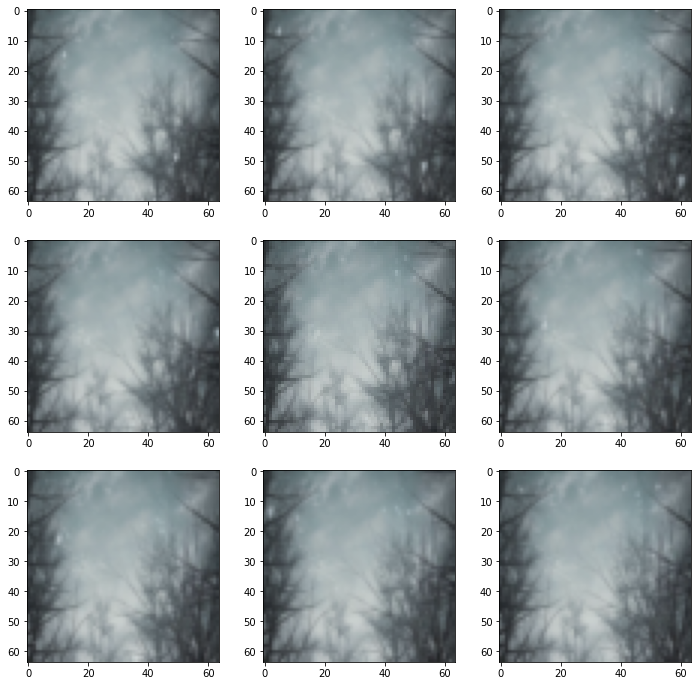

In [11]:
display_images(train_ds[100][0])
plt.show()

In [14]:
with strategy.scope():
    vqgan = VQGAN(num_embeddings=128, embedding_dim=128, train_variance=train_var, disc_iter_start=227 * 100)

Working with z of shape (1, 128, 8, 8) = 8192 dimensions.
VQLPIPSWithDiscriminator running with hinge loss.


In [15]:
with strategy.scope():
    vqgan.compile(gen_optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), disc_optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5))
history = vqgan.fit(train_ds, epochs=10)

2022-05-18 04:40:32.030746: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_458899"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:117"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

Epoch 1/10
INFO:tensorflow:batch_all_reduce: 201 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 201 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
227/227 [==============================] - 399s 409ms/step - loss: 16.2615 - reconstruction_loss: 7.4306 - vqvae_loss: 7.8281 - disc_loss: 0.0000e+00
Epoch 2/10
227/227 [==============================] - 47s 209ms/step - loss: 43.8360 - reconstruction_loss: 4.4511 - vqvae_loss: 38.8322 - disc_loss: 0.0000e+00
Epoch 3/10
227/227 [==============================] - 48s 209ms/step - loss: 26.1462 - reconstruction_loss: 3.0337 - vqvae_loss: 22.8932 - disc_loss: 0.0000e+00
Epoch 4/10
227/227 [==============================] - 48s 210ms/step - loss: 16.3004 - reconstruction_loss: 2.4022 - vqvae_loss: 13.8071 - disc_loss: 0.0000e+00
Epoch 5/10

In [17]:
x = train_ds[100][0]
generated = vqgan(x[:10])

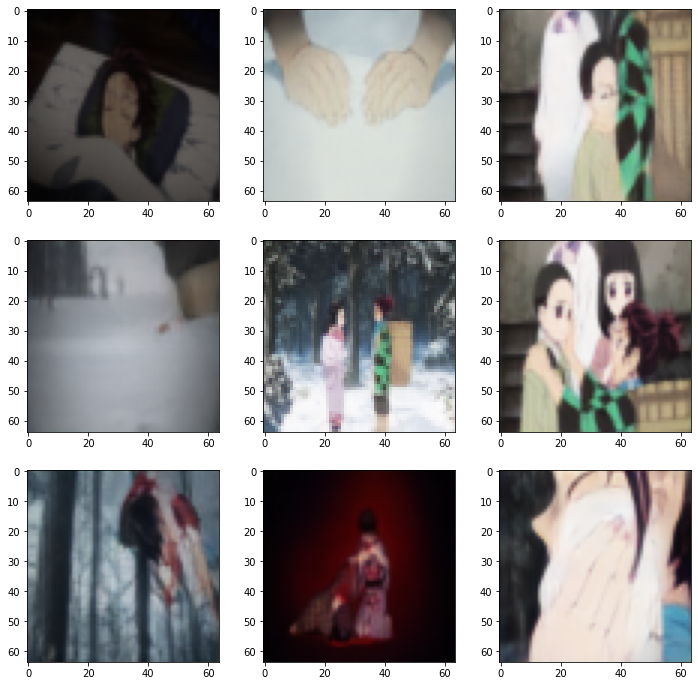

In [18]:
display_images(generated)
plt.show()

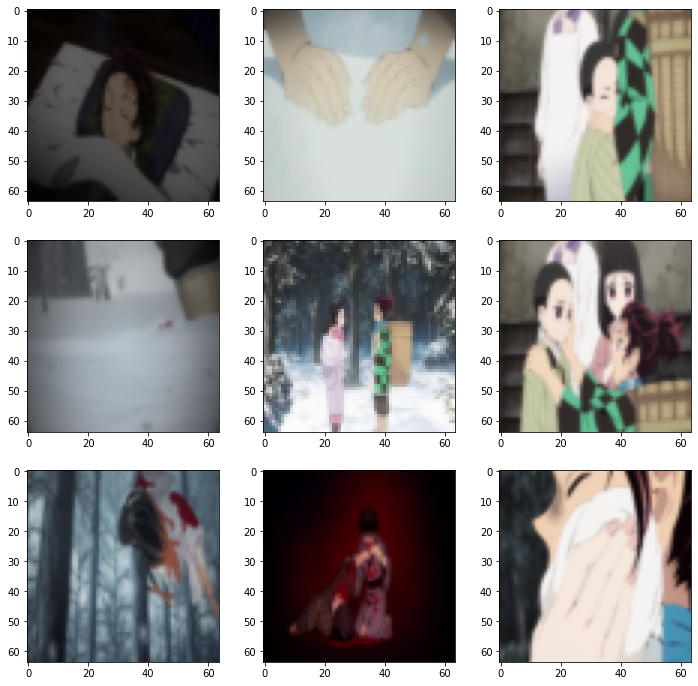

In [19]:
display_images(x)
plt.show()

In [20]:
x2 = train_ds[30][0]
generated2 = vqgan(x2[:10])

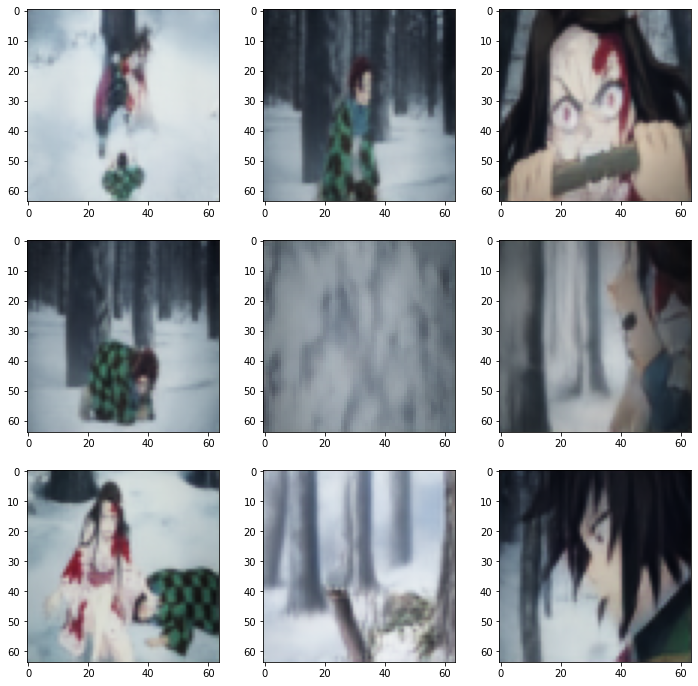

In [21]:
display_images(generated2)
plt.show()

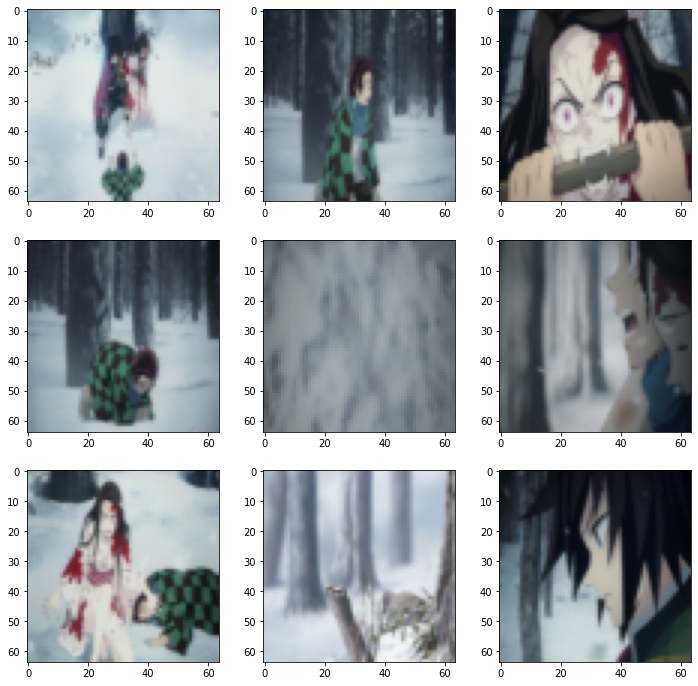

In [22]:
display_images(x2)
plt.show()